In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from AFP_all import sech, AFP_rf
from AHP_all import AHP_rf
from AM_pulses import AM_rf
from BIR4 import BIR4_rf
from CHIRP import chirp_rf
from multi_freq import multi_freq

%matplotlib notebook

# OPTION 1: Directly generate the RF pulse to simulate 

In [11]:
"""
Available shaped pulse functions:
Amplitude Modulated (AM_rf): 'sinc', 'gaussian', 'hermite', 'square'
Adiabatic Full/Half Passage (AFP_rf/AHP_rf): 'HSn', 'tanh/tan'
B1 Insensitive Rotation (BIR4): 'tanh/tan', 'sech/tanh'
CHIRP Linear frequency sweep: chirp_rf
"""
pulse_length = 2000  #us
shape_pts = 256
rf, fm, pm, time = AFP_rf(shape_pts=shape_pts, pulse_length=pulse_length, func='HSn', n=8, sweep_bw=10000)

# OPTION 2: Load a previously saved pulse from one of the other pulse functions (except SLR)
### Don't use if using OPTION 1

In [5]:
BASE_RF_FILE = "C:/Users/RudrakshaMajumdar/Documents/GitHub/rf-bloch-simulator/saved_rf_pulses/sinc3_2ms/rf_pulse_file.npz"
BASE_RF_PULSE = np.load(BASE_RF_FILE)

rf = BASE_RF_PULSE['arr_0']
pm = BASE_RF_PULSE['arr_1']
fm = BASE_RF_PULSE['arr_2']
time = BASE_RF_PULSE['arr_5']

# RF pulse parameters
pulse_length = 2000  #us
shape_pts = len(rf)  # points in shaped pulse

# Plot the shape

<IPython.core.display.Javascript object>


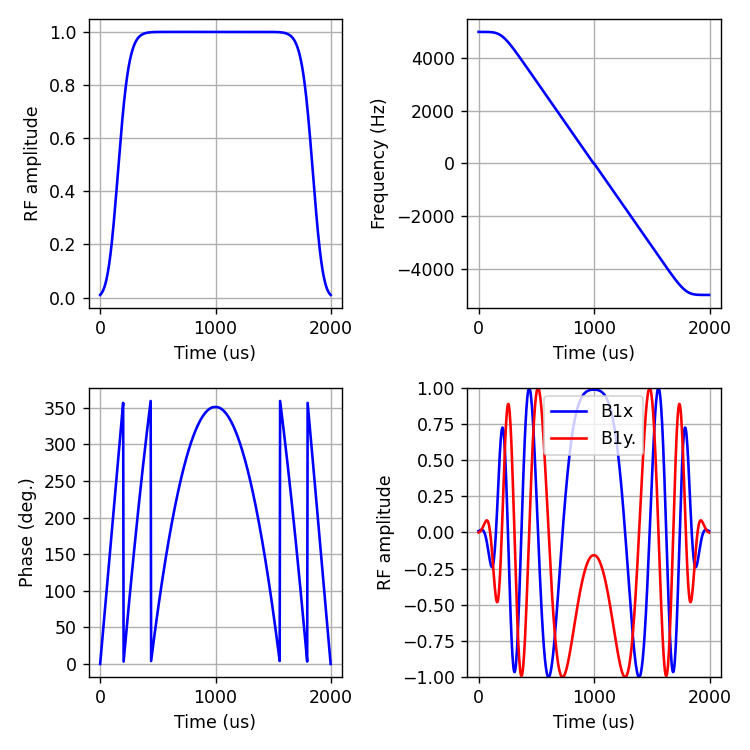

In [12]:
# Convert degrees to radians for complex plot
pm_rad = np.deg2rad(pm)

fig = plt.figure(figsize=[6,6])

plt_rfamp = fig.add_subplot(221)
plt_fm = fig.add_subplot(222)
plt_pm = fig.add_subplot(223)
plt_complex = fig.add_subplot(224)

plt_rfamp.plot(time, rf, 'b')
plt_rfamp.set_ylabel("RF amplitude")
plt_rfamp.set_xlabel("Time (us)")
plt_rfamp.grid()

plt_fm.plot(time,fm, 'b')
plt_fm.set_ylabel("Frequency (Hz)")
plt_fm.set_xlabel("Time (us)")
plt_fm.grid()

plt_pm.plot(time,pm, 'b')
plt_pm.set_ylabel("Phase (deg.)")
plt_pm.set_xlabel("Time (us)")
plt_pm.grid()

plt_complex.plot(time, rf * np.cos(pm_rad), 'b', label = "B1x")
plt_complex.plot(time, rf * np.sin(pm_rad), 'r', label = "B1y.")
plt_complex.set_ylabel("RF amplitude")
plt_complex.set_xlabel("Time (us)")
plt_complex.set_ylim(-1,1)
plt_complex.legend()
plt_complex.grid()


plt.tight_layout()
plt.show()

# Set up the simulation conditions

In [13]:
# Gyromagnetic ratio in MHz/T
gamma = 42.57
# Declare initial magnetization [Mx,My,Mz]
init_mag = np.array([0,0,1])

# Set Simulation parameters
sim_points = 200

rf_min = 0
rf_max = 5000

freq_offset=0
freq_min = -5000
freq_max = 5000

# Simulate the pulse amplitude profile

<IPython.core.display.Javascript object>


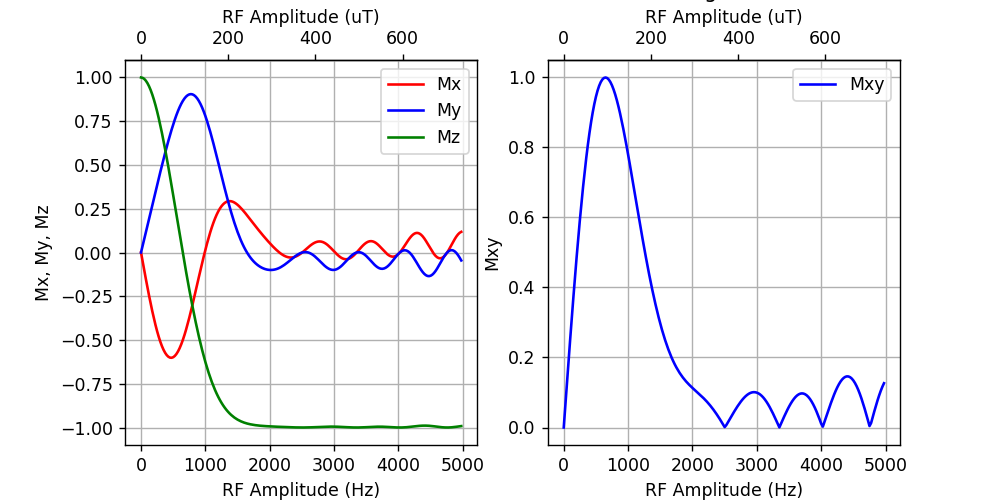

Text(0.5, 0, 'RF Amplitude (uT)')

In [14]:
def RF_AMP_SIM(
    pulse_length=pulse_length,
    sim_points = sim_points,
    rf_min = rf_min,
    rf_max = rf_max,
    freq_offset=freq_offset,
    init_mag = init_mag
):
    """
    A function to simulate magnetization as a function 
    of RF amplitude. In the current version, the pulse
    needs to be pre-loaded outside the function.
    """
    
    rf_amp = rf
    rf_dwelltime = 1e-6 * (pulse_length/rf.size)  # convert to seconds

    # Convert rf phase from degrees to radians
    rf_phase = (np.pi/180) * pm

    # Convert freq offset from Hz to radians/sec
    rf_offset = 2 * np.pi * freq_offset

    # Initial magnetizations
    Mx_0 = init_mag[0]
    My_0 = init_mag[1]
    Mz_0 = init_mag[2]

    # x-axis step size
    rf_step = (rf_max - rf_min)/sim_points

    # rf amplitude range for x-axis
    rf_range = np.arange(rf_min,rf_max,rf_step)

    # Scale Scale RF pulse over the entire RF range and convert from Hz to rad/s
    rf_amp = 2 * np.pi * rf_range.reshape(-1,1) * rf_amp.reshape(1,-1)  #can also use np.outer

    # Memory allocation
    Mx = np.zeros(sim_points)
    My = np.zeros(sim_points)
    Mz = np.zeros(sim_points)

    Rx = np.identity(3)
    Ry = np.identity(3)
    Ry2 = np.identity(3)
    Rz = np.identity(3)
    Rz2 = np.identity(3)

    M = np.zeros([3,1])

    # Start Simulation
    for rf_range_counter in range(sim_points):
        M[0,0] = Mx_0
        M[1,0] = My_0
        M[2,0] = Mz_0

        for rf_pulse_counter in range(rf.size):
            term_0 = rf_amp[rf_range_counter, rf_pulse_counter] ** 2
            term_1 = rf_offset ** 2

            #B_effective
            Be = np.sqrt(term_0 + term_1) * rf_dwelltime
            alpha = np.arctan2(rf_offset, rf_amp[rf_range_counter,rf_pulse_counter])

            # Precalculate various sin/cos terms for increased speed
            cosBe = np.cos(Be)
            sinBe = np.sin(Be)
            cosalpha = np.cos(alpha)
            sinalpha = np.sin(alpha)
            cosphi = np.cos(rf_phase[rf_pulse_counter])
            sinphi = np.sin(rf_phase[rf_pulse_counter])

            # Construct the total rotation matrix
            Rx[1,1] = cosBe
            Rx[1,2] = sinBe
            Rx[2,1] = -1.0 * sinBe
            Rx[2,2] = cosBe

            Ry[0,0] = cosalpha
            Ry[0,2] = -1.0 * sinalpha
            Ry[2,0] = sinalpha
            Ry[2,2] = cosalpha

            Ry2[0,0] = cosalpha
            Ry2[0,2] = sinalpha
            Ry2[2,0] = -1.0 * sinalpha
            Ry2[2,2] = cosalpha

            Rz[0,0] = cosphi
            Rz[0,1] = sinphi
            Rz[1,0] = -1.0 * sinphi
            Rz[1,1] = cosphi

            Rz2[0,0] = cosphi
            Rz2[0,1] = -1.0 * sinphi
            Rz2[1,0] = sinphi
            Rz2[1,1] = cosphi

            M = np.linalg.multi_dot([Rz, Ry, Rx, Ry2, Rz2, M])

        Mx[rf_range_counter] = M[0,0]
        My[rf_range_counter] = M[1,0]
        Mz[rf_range_counter] = M[2,0]
    
    Mxy = np.sqrt(Mx**2 + My**2)
    
    return(Mx, My, Mz, Mxy, rf_range, rf_amp)

Mx, My, Mz, Mxy, rf_range, rf_amp = RF_AMP_SIM()

def hz_2_uT(value):
    return value * 2 * np.pi / gamma

def uT_2_hz(value):
    return value * gamma / 2 * np.pi
    
    
fig = plt.figure(figsize=[8,4])
plt_all = fig.add_subplot(121)
plt_Mxy = fig.add_subplot(122)
plt.title("Pulse length: " + str(pulse_length) + " us", loc='center')

plt_all.plot(rf_range,Mx, 'r', label = "Mx")
plt_all.plot(rf_range,My, 'b', label = "My")
plt_all.plot(rf_range,Mz, 'g', label = "Mz")
plt_all.legend()
plt_all.set_xlabel("RF Amplitude (Hz)")
plt_all.set_ylabel("Mx, My, Mz")
plt_all.grid()

second_axis_all = plt_all.secondary_xaxis('top', functions = (hz_2_uT, uT_2_hz))
second_axis_all.set_xlabel("RF Amplitude (uT)")

plt_Mxy.plot(rf_range, Mxy, 'b', label = "Mxy")
plt_Mxy.legend()
plt_Mxy.set_xlabel("RF Amplitude (Hz)")
plt_Mxy.set_ylabel("Mxy")
plt_Mxy.grid()

second_axis_Mxy = plt_Mxy.secondary_xaxis('top', functions = (hz_2_uT, uT_2_hz))
second_axis_Mxy.set_xlabel("RF Amplitude (uT)")

# Simulate the pulse frequency profile
### Use an appropriate amplitude from the amplitude profile
### usually corresponding to a 90 or 180 pulse

<IPython.core.display.Javascript object>


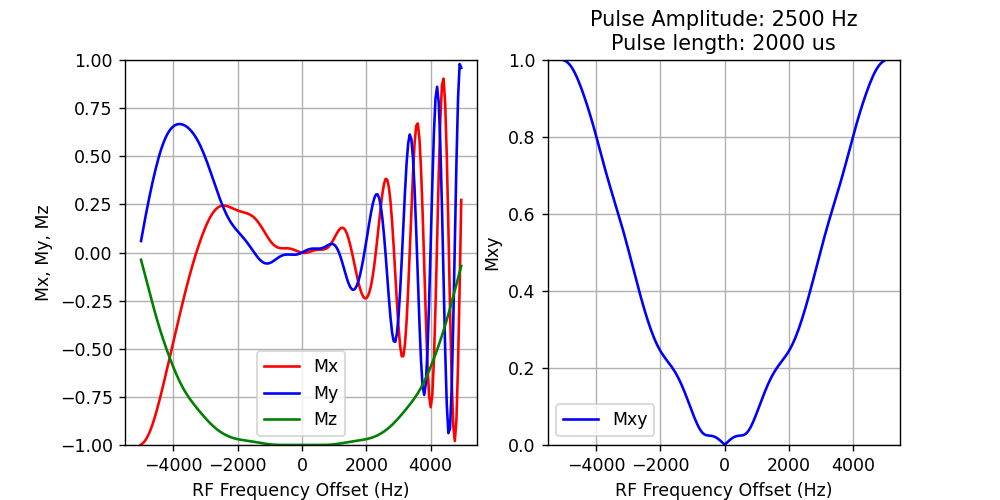

In [15]:
rf_amplitude = 2500
def RF_FREQ_SIM(
    pulse_length = pulse_length,
    sim_points = sim_points,
    freq_min = freq_min,
    freq_max = freq_max,
    rf_amplitude = rf_amplitude,
    freq_offset=freq_offset,
    init_mag = init_mag
):
    """
    A function to simulate magnetization as a function 
    of Frequency Offset. In the current version, the pulse
    needs to be pre-loaded outside the function.
    """
    
    rf_amp = rf
    rf_dwelltime = 1e-6 * (pulse_length/rf.size)  # convert to seconds

    # Convert rf phase from degrees to radians
    rf_phase = (np.pi/180) * pm
    
    # Initial magnetizations
    Mx_0 = init_mag[0]
    My_0 = init_mag[1]
    Mz_0 = init_mag[2]

    # x-axis step size
    freq_step = (freq_max - freq_min)/sim_points

    # rf frequency offset range for x-axis
    freq_range = np.arange(freq_min,freq_max,freq_step)

    # Scale Scale RF pulse over the entire RF range and convert from Hz to rad/s
    rf_amp = 2 * np.pi * rf_amplitude * rf_amp.reshape(-1,1)  

    # Memory allocation
    Mx = np.zeros(sim_points)
    My = np.zeros(sim_points)
    Mz = np.zeros(sim_points)

    Rx = np.identity(3)
    Ry = np.identity(3)
    Ry2 = np.identity(3)
    Rz = np.identity(3)
    Rz2 = np.identity(3)

    M = np.zeros([3,1])

    # Start Simulation
    for freq_range_counter in range(sim_points):
        
        M[0,0] = Mx_0
        M[1,0] = My_0
        M[2,0] = Mz_0
        
        # Convert frequency offset from Hz to rad/s
        rf_offset = 2 * np.pi * freq_range[freq_range_counter]

        for rf_pulse_counter in range(rf.size):
            term_0 = rf_amp[rf_pulse_counter] ** 2
            term_1 = rf_offset ** 2

            #B_effective
            Be = np.sqrt(term_0 + term_1) * rf_dwelltime
            alpha = np.arctan2(rf_offset, rf_amp[rf_pulse_counter])

            # Precalculate various sin/cos terms for increased speed
            cosBe = np.cos(Be)
            sinBe = np.sin(Be)
            cosalpha = np.cos(alpha)
            sinalpha = np.sin(alpha)
            cosphi = np.cos(rf_phase[rf_pulse_counter])
            sinphi = np.sin(rf_phase[rf_pulse_counter])

            # Construct the total rotation matrix
            Rx[1,1] = cosBe
            Rx[1,2] = sinBe
            Rx[2,1] = -1.0 * sinBe
            Rx[2,2] = cosBe

            Ry[0,0] = cosalpha
            Ry[0,2] = -1.0 * sinalpha
            Ry[2,0] = sinalpha
            Ry[2,2] = cosalpha

            Ry2[0,0] = cosalpha
            Ry2[0,2] = sinalpha
            Ry2[2,0] = -1.0 * sinalpha
            Ry2[2,2] = cosalpha

            Rz[0,0] = cosphi
            Rz[0,1] = sinphi
            Rz[1,0] = -1.0 * sinphi
            Rz[1,1] = cosphi

            Rz2[0,0] = cosphi
            Rz2[0,1] = -1.0 * sinphi
            Rz2[1,0] = sinphi
            Rz2[1,1] = cosphi

            M = np.linalg.multi_dot([Rz, Ry, Rx, Ry2, Rz2, M])

        Mx[freq_range_counter] = M[0,0]
        My[freq_range_counter] = M[1,0]
        Mz[freq_range_counter] = M[2,0]
    
    Mxy = np.sqrt(Mx**2 + My**2)
    
    return(Mx, My, Mz, Mxy, freq_range)

Mx, My, Mz, Mxy, freq_range = RF_FREQ_SIM()
    
fig = plt.figure(figsize=[8,4])
plt_all = fig.add_subplot(121)
plt_Mxy = fig.add_subplot(122)
plt.title(
    "Pulse Amplitude: "
    + str(rf_amplitude)
    + " Hz"
    + "\nPulse length: "
    + str(pulse_length) +
    " us"
  )

plt_all.plot(freq_range,Mx, 'r', label = "Mx")
plt_all.plot(freq_range,My, 'b', label = "My")
plt_all.plot(freq_range,Mz, 'g', label = "Mz")
plt_all.set_ylim(-1,1)
plt_all.legend()
plt_all.set_xlabel("RF Frequency Offset (Hz)")
plt_all.set_ylabel("Mx, My, Mz")
plt_all.grid()

plt_Mxy.plot(freq_range, Mxy, 'b', label = "Mxy")
plt_Mxy.set_ylim(0,1)
plt_Mxy.legend()
plt_Mxy.set_xlabel("RF Frequency Offset (Hz)")
plt_Mxy.set_ylabel("Mxy")
plt_Mxy.grid()

# Simulate the magnetization trajectory over time

<IPython.core.display.Javascript object>


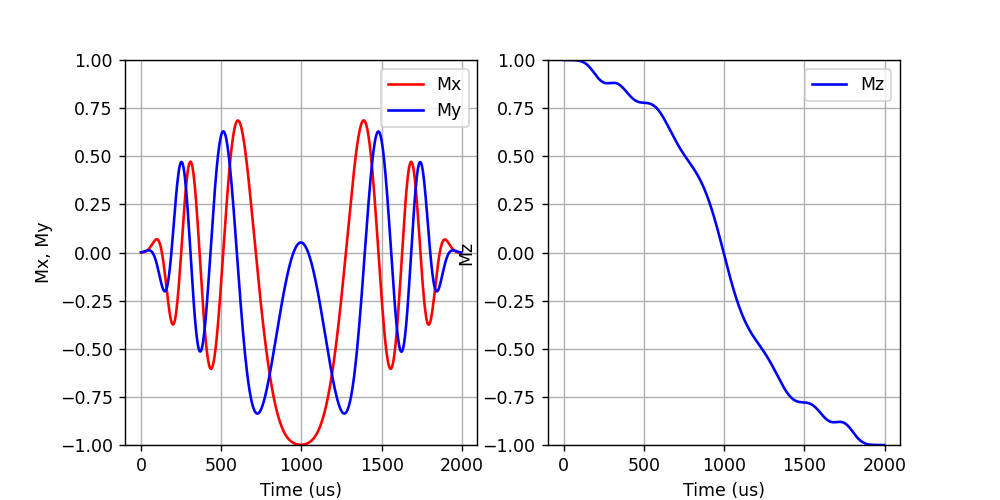

<IPython.core.display.Javascript object>


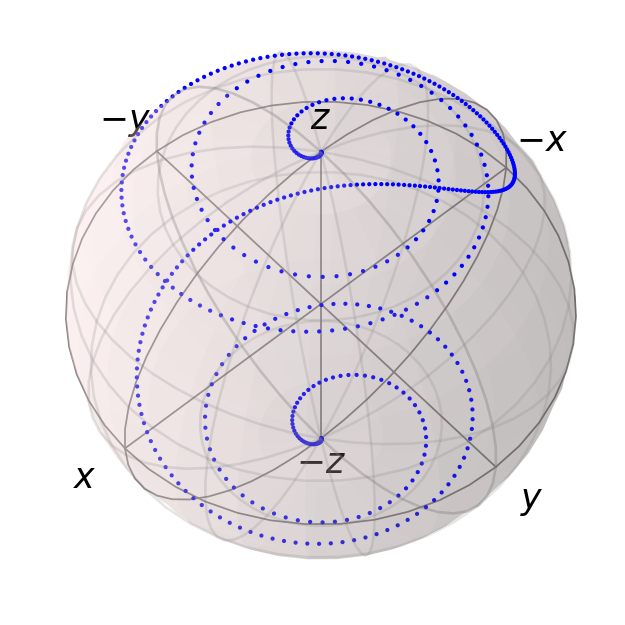

In [16]:
def RF_TIME_SIM(
    pulse_length = pulse_length,
    rf_amplitude = rf_amplitude,
    freq_offset = freq_offset,
    init_mag = init_mag
):
    """
    A function to simulate magnetization as a function 
    of time and on the Bloch sphere. In the current version, the pulse
    needs to be pre-loaded outside the function.
    """

    rf_amp = rf
    rf_dwelltime = 1e-6 * (pulse_length/rf.size)  # convert to seconds
    time_axis = np.arange(0, pulse_length, pulse_length/rf.size) 

    # Convert rf phase from degrees to radians
    rf_phase = (np.pi/180) * pm

    # Initial magnetizations
    Mx_0 = init_mag[0]
    My_0 = init_mag[1]
    Mz_0 = init_mag[2]


    # Scale Scale RF pulse over the entire RF range and convert from Hz to rad/s
    rf_amp = 2 * np.pi * rf_amplitude * rf_amp.reshape(-1,1)  

    # Memory allocation
    Mx = np.zeros(rf.size)
    My = np.zeros(rf.size)
    Mz = np.zeros(rf.size)

    Rx = np.identity(3)
    Ry = np.identity(3)
    Ry2 = np.identity(3)
    Rz = np.identity(3)
    Rz2 = np.identity(3)

    M = np.zeros([3,1])

    # Start Simulation

    M[0,0] = Mx_0
    M[1,0] = My_0
    M[2,0] = Mz_0

    # Convert frequency offset from Hz to rad/s
    rf_offset = 2 * np.pi * freq_offset

    for rf_pulse_counter in range(rf.size):

        term_0 = rf_amp[rf_pulse_counter] ** 2
        term_1 = rf_offset ** 2

        #B_effective
        Be = np.sqrt(term_0 + term_1) * rf_dwelltime
        alpha = np.arctan2(rf_offset, rf_amp[rf_pulse_counter])

        # Precalculate various sin/cos terms for increased speed
        cosBe = np.cos(Be)
        sinBe = np.sin(Be)
        cosalpha = np.cos(alpha)
        sinalpha = np.sin(alpha)
        cosphi = np.cos(rf_phase[rf_pulse_counter])
        sinphi = np.sin(rf_phase[rf_pulse_counter])

        # Construct the total rotation matrix
        Rx[1,1] = cosBe
        Rx[1,2] = sinBe
        Rx[2,1] = -1.0 * sinBe
        Rx[2,2] = cosBe

        Ry[0,0] = cosalpha
        Ry[0,2] = -1.0 * sinalpha
        Ry[2,0] = sinalpha
        Ry[2,2] = cosalpha

        Ry2[0,0] = cosalpha
        Ry2[0,2] = sinalpha
        Ry2[2,0] = -1.0 * sinalpha
        Ry2[2,2] = cosalpha

        Rz[0,0] = cosphi
        Rz[0,1] = sinphi
        Rz[1,0] = -1.0 * sinphi
        Rz[1,1] = cosphi

        Rz2[0,0] = cosphi
        Rz2[0,1] = -1.0 * sinphi
        Rz2[1,0] = sinphi
        Rz2[1,1] = cosphi

        M = np.linalg.multi_dot([Rz, Ry, Rx, Ry2, Rz2, M])

        Mx[rf_pulse_counter] = M[0,0]
        My[rf_pulse_counter] = M[1,0]
        Mz[rf_pulse_counter] = M[2,0]
        
    return(Mx, My, Mz, time_axis)

Mx, My, Mz, time_axis = RF_TIME_SIM()



# Plotting
fig = plt.figure(figsize=[8,4])
plt_Mx_y = fig.add_subplot(121)
plt_Mz = fig.add_subplot(122)

plt_Mx_y.plot(time_axis,Mx, 'r', label = "Mx")
plt_Mx_y.plot(time_axis,My, 'b', label = "My")
plt_Mx_y.set_ylim(-1,1)
plt_Mx_y.set_xlabel("Time (us)")
plt_Mx_y.set_ylabel("Mx, My")
plt_Mx_y.legend()
plt_Mx_y.grid()

plt_Mz.plot(time_axis,Mz, 'b', label = "Mz")
plt_Mz.set_ylim(-1,1)
plt_Mz.set_xlabel("Time (us)")
plt_Mz.set_ylabel("Mz")
plt_Mz.legend()
plt_Mz.grid()

# Bloch sphere
bloch = Bloch()
pnts = [Mx, My, Mz]
bloch.add_points(pnts)
bloch.point_size = [2, 2, 2, 2]
bloch.xlabel = ['$x$', '$-x$']
bloch.ylabel = ['$y$', '$-y$']
bloch.zlabel = ['$z$', '$-z$']
bloch.show()